## README:

1. Run the pre processing part as it is:

2. Can independently run the model sections. (no need to run the statsmodels)

3. The best one is the neural network one which is at the last part.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/mk/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Preprocessing

In [3]:
prices = 'Documents and Data for forecasting LOCUS/Price forecasting/Price Forecasting data upto December 24.csv'
prices_df = pd.read_csv(prices)

In [39]:
prices_df = prices_df.dropna()

<Axes: >

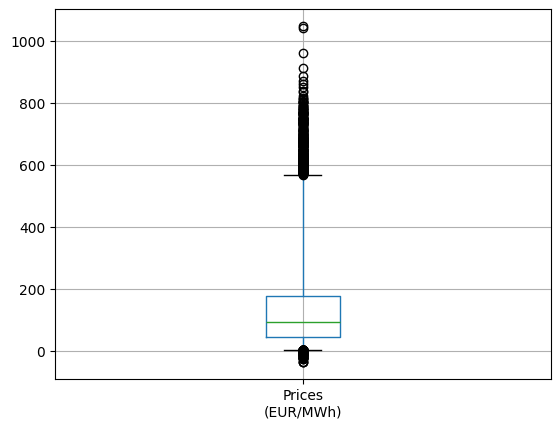

In [4]:
prices_df.boxplot(whis=[1,99])

In [5]:
prices_df.head()

,Delivery Day,Hours,Prices\n(EUR/MWh)
0,1/1/2020,H1,26.38
1,1/1/2020,H2,26.50
2,1/1/2020,H3,27.01
3,1/1/2020,H4,27.40
4,1/1/2020,H5,27.99


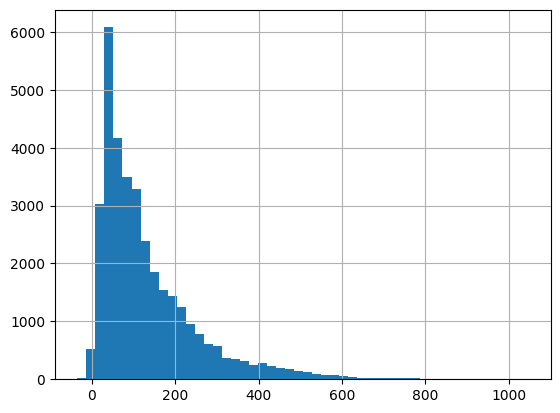

In [6]:
plt.cla()
prices_df['Prices\n(EUR/MWh)'].hist(bins=50)
plt.show()

# Try statsmodels

In [345]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(prices_df['Prices\n(EUR/MWh)'])

In [346]:
# Print the ADF test result
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

# Interpete the result
is_stationary = result[1] <= 0.05  # Using a common significance level of 0.05
if is_stationary:
    print("The time series is likely stationary.")
else:
    print("The time series is likely non-stationary.")

ADF Statistic: -12.479372467163827
p-value: 3.116127405608279e-23
Critical Values: {'1%': -3.430537692845807, '5%': -2.861622955587909, '10%': -2.566814154654271}
The time series is likely stationary.


In [347]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

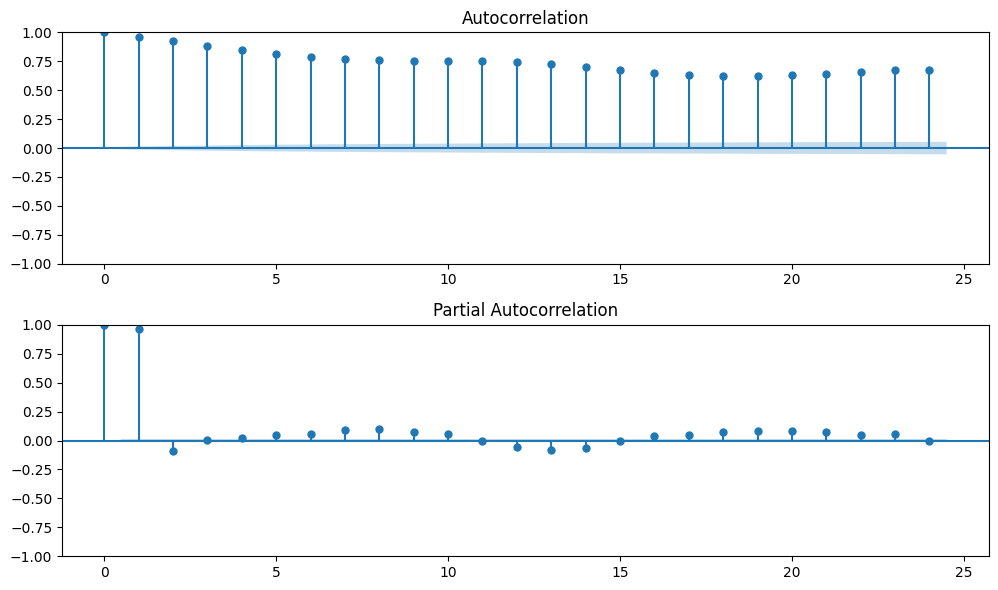

In [348]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(prices_df['Prices\n(EUR/MWh)'], ax=ax1, lags=24)
plot_pacf(prices_df['Prices\n(EUR/MWh)'], ax=ax2, lags=24)
plt.tight_layout()
plt.show()

In [349]:
order = (6, 0, 1)
arima_model = ARIMA(prices_df['Prices\n(EUR/MWh)'][:-24*7], order=order)
fit_model = arima_model.fit()

In [213]:
forecast_steps = 24*7
forecast = fit_model.forecast(steps=forecast_steps)

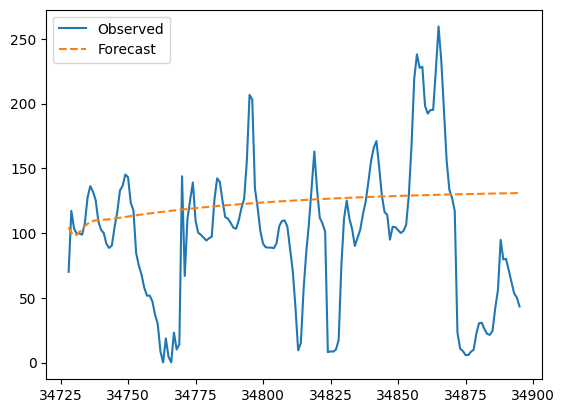

In [214]:
plt.plot(prices_df['Prices\n(EUR/MWh)'][-24*7:], label='Observed')
plt.plot(range(len(prices_df)-forecast_steps, len(prices_df)), forecast, label='Forecast', linestyle='dashed')
plt.legend()
plt.show()

# Modern Techniques

In [14]:
def create_time_series_sequences(prices_df, sequence_length, add_times=False):
    sequences, targets = [], []

    for i in range(len(prices_df) - sequence_length):
        seq = prices_df['Prices\n(EUR/MWh)'].values[i:i+sequence_length]

        if add_times:

            delivery_day = pd.to_datetime(prices_df['Delivery Day'].values[i+sequence_length])
            month, day = delivery_day.month, delivery_day.day
            seq = np.append(seq, month)
            seq = np.append(seq, day) 

            hour = int(prices_df['Hours'].values[i+sequence_length][1:])
            seq = np.append(seq, hour)

        target = prices_df['Prices\n(EUR/MWh)'].values[i+sequence_length]

        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

In [15]:
sequence_length = 24*7
X, y = create_time_series_sequences(prices_df, sequence_length, add_times=False)

In [16]:
X.shape, y.shape

((35184, 168), (35184,))

In [17]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
split_index = int(0.8*len(prices_df))
# split_index = len(df)-7*24
X_train, X_test, y_train, y_test = X[:split_index], X[split_index:], y[:split_index], y[split_index:]

In [18]:
X_train.shape, X_test.shape

((28281, 168), (6903, 168))

# BiLSTM

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.optim as optim

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [21]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

In [24]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*hidden_size, 1)

    def forward(self, x, target = None):
        batch_size, sequence_length = x.shape
        h0 = torch.zeros(2*self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(2*self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        x = x.view(batch_size, sequence_length, 1)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]).squeeze(dim=-1)
        loss = None
        if target is not None:
            loss = F.mse_loss(out, target)
        return out, loss

In [25]:
input_size = 1
hidden_size = 50
num_stacked_layers = 5
bilstm = BiLSTM(input_size, hidden_size, num_stacked_layers)

In [19]:
for batch_X, batch_y in train_loader:
    print(batch_X.shape, batch_y.shape)
    break

torch.Size([64, 168]) torch.Size([64])


In [20]:
optimizer = torch.optim.Adam(bilstm.parameters(), lr=0.001)

In [21]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Train the BiLSTM

from tqdm import tqdm

bilstm.train()
bilstm.to(device)
best_val_loss = float('inf')

epochs = 100
for epoch in range(epochs):
    train_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        _, loss = bilstm(inputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    average_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {average_train_loss:.4f}")

    bilstm.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, loss = bilstm(inputs, labels)
            test_loss += loss.item()

    average_val_loss = test_loss / len(test_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Test Loss: {average_val_loss:.4f}")

    if average_val_loss+average_train_loss < best_val_loss:
        print("Best model found at epoch: ", {epoch+1})
        best_val_loss = average_val_loss + average_train_loss
        best_model_state_dict = bilstm.state_dict()

    bilstm.train()

torch.save(best_model_state_dict, 'best_model.pth')

In [22]:
X_train[-1]

array([119.75, 100.1 ,  89.03,  86.21,  88.79, 109.58, 126.92, 173.57,
       180.31, 171.02, 194.14, 120.99,  92.98,  94.13,  76.98, 132.75,
        97.85,  96.86,  91.81,  89.92,  94.53, 115.7 , 131.35, 150.  ,
       137.7 , 132.87, 136.09, 137.37, 133.61, 133.27, 133.48, 137.98,
       137.31, 136.22, 132.06, 124.73, 112.11, 107.17,  87.08,  83.32,
        88.35,  76.64,  60.03,  76.18,  73.39,  81.64,  90.82,  95.71,
       105.82, 106.83, 103.87, 101.69,  99.  , 104.29, 110.12, 135.03,
       143.54, 133.  , 133.66, 129.83, 110.74, 100.79,  81.26,  99.2 ,
       155.57, 150.05, 148.24, 145.97, 152.78, 175.78, 196.64, 220.07,
       180.98, 149.15, 144.23, 144.4 , 144.47, 155.61, 162.53, 170.14,
       183.99, 192.45, 182.07, 163.49, 155.24, 136.31, 130.26,  94.17,
       113.19, 112.02, 111.  , 111.  , 118.23, 140.68, 158.53, 173.1 ,
       163.29, 154.49, 144.81, 138.37, 134.35, 141.26, 143.2 , 145.19,
       153.22, 166.89, 170.02, 153.77, 139.75, 132.55, 119.  , 160.54,
      

In [40]:
#Load the save model for inference:

bilstm_sd = torch.load('prices_model.pth')
input_size = 1
hidden_size = 50
num_stacked_layers = 5
bilstm = BiLSTM(input_size, hidden_size, num_stacked_layers)
bilstm.load_state_dict(bilstm_sd['model_state_dict'])

<All keys matched successfully>

In [74]:
predict_size = 24*7

bilstm.eval()
bilstm.to(device)

lstm_features = prices_df['Prices\n(EUR/MWh)'][-predict_size:].values[np.newaxis, :]

lstm_features = torch.tensor(lstm_features, dtype=torch.float32).to(device)

for _ in range(predict_size):
    lstm_in_features = lstm_features[:, -24*7:]
    next, _ = bilstm(lstm_in_features)
    lstm_features = torch.cat((lstm_features, next[np.newaxis, :]), dim=-1)

lstm_features.shape

lstm_features = lstm_features[0].detach().cpu()

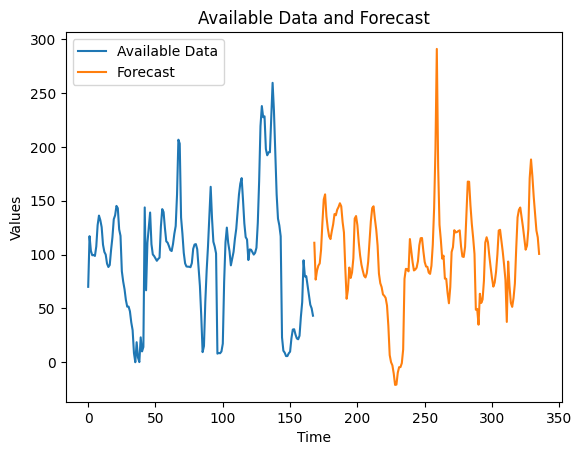

In [78]:
half_length = lstm_features.shape[0] // 2
available_data = lstm_features[:half_length]
forecast = lstm_features[half_length:]

# Plotting
plt.plot(np.arange(half_length), available_data, label='Available Data')
plt.plot(np.arange(half_length, len(lstm_features)), forecast, label='Forecast')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Available Data and Forecast')
plt.legend()
plt.show()

In [81]:
predicted_list = lstm_features[168:]

In [84]:
from datetime import datetime, timedelta

# Example data
start_date = datetime(2024, 12, 25)
num_hours = len(predicted_list) 

# Generate datetime values for the first column
date_times = [start_date + timedelta(hours=i) for i in range(num_hours)]
formatted_date_times = [dt.strftime('%m/%d/%Y') for dt in date_times]

hours = [f'H{i}' for i in range(1, 25)] * 7

# Forcasted price df
forcasted_df = pd.DataFrame({
    'Delivery Day': formatted_date_times,
    'Hours': hours,
    'Prices\n(EUR/MWh)': predicted_list
})

# Save the DataFrame to a CSV file
forcasted_df.to_csv('prices_forecast_df.csv', index=False, float_format='%.2f')

print("CSV file created successfully.")

CSV file created successfully.


In [85]:
merged_forcasted_df = pd.read_csv("prices_forecast_df.csv")

merged_prices_df = pd.concat([prices_df, forcasted_df], ignore_index=True)
merged_prices_df.to_csv("prices_merged_forecast_df.csv", index=False, float_format='%.2f')

In [88]:
merged_prices_df.tail(168)

,Delivery Day,Hours,Prices\n(EUR/MWh)
34896,12/25/2024,H1,110.967720
34897,12/25/2024,H2,76.773338
34898,12/25/2024,H3,85.132172
34899,12/25/2024,H4,89.729134
34900,12/25/2024,H5,91.782364
...,...,...,...
35059,12/31/2024,H20,153.643204
35060,12/31/2024,H21,138.507278
35061,12/31/2024,H22,122.336205
35062,12/31/2024,H23,116.027046
